In [1]:
# for data manipulation
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

# for data evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, \
                            recall_score, f1_score, plot_roc_curve, roc_auc_score, average_precision_score, \
                            precision_recall_curve


In [2]:
# create a function to run the metrics and store it in dataframe
evaluation_list = []

def run_score(fit_model, model, scale=False):
    
    summary_dict = {}

    if scale:
        y_pred = fit_model.predict(X_test_sc)
        train = fit_model.score(X_train_sc, y_train)
        test = fit_model.score(X_test_sc, y_test)
        roc_auc = roc_auc_score(y_test, fit_model.predict_proba(X_test_sc)[:,1])

        # store the results in summary dictionary
        summary_dict['model'] = model
        summary_dict['train accuracy'] = train
        summary_dict['test accuracy'] = test
        summary_dict['precision'] = precision_score(y_test, y_pred)
        summary_dict['recall'] = recall_score(y_test, y_pred)
        summary_dict['average precision'] = average_precision_score(y_test, y_pred)
        summary_dict['f1_score'] = f1_score(y_test, y_pred)
        summary_dict['roc_auc'] = roc_auc

        evaluation_list.append(summary_dict)

        # print summarize results
        print(f"====== {model}'s Metrics ======")
        print(f"Train Score: {train}")
        print(f"Test Score: {test}")    
        print(f"Precision Score: {precision_score(y_test, y_pred)}")
        print(f"Recall Score: {recall_score(y_test, y_pred)}")
        print(f"Average Precision: {average_precision_score(y_test, y_pred)}")
        print(f"f1-Score: {f1_score(y_test, y_pred)}")
        print(f"roc_auc Score: {roc_auc}")

        print()
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        print('== confusion matrix ==')
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")
    
    else:      
        y_pred = fit_model.predict(X_test)
        train = fit_model.score(X_train, y_train)
        test = fit_model.score(X_test, y_test)
        roc_auc = roc_auc_score(y_test, fit_model.predict_proba(X_test)[:,1])

        # store the results in summary dictionary
        summary_dict['model'] = model
        summary_dict['train accuracy'] = train
        summary_dict['test accuracy'] = test
        summary_dict['precision'] = precision_score(y_test, y_pred)
        summary_dict['recall'] = recall_score(y_test, y_pred)
        summary_dict['average precision'] = average_precision_score(y_test, y_pred)
        summary_dict['f1_score'] = f1_score(y_test, y_pred)
        summary_dict['roc_auc'] = roc_auc

        evaluation_list.append(summary_dict)

        # print summarize results
        print(f"====== {model}'s Metrics ======")
        print(f"Train Score: {train}")
        print(f"Test Score: {test}")    
        print(f"Precision Score: {precision_score(y_test, y_pred)}")
        print(f"Recall Score: {recall_score(y_test, y_pred)}")
        print(f"Average Precision: {average_precision_score(y_test, y_pred)}")
        print(f"f1-Score: {f1_score(y_test, y_pred)}")
        print(f"roc_auc Score: {roc_auc}")

        print()
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        print('== confusion matrix ==')
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")

Precision measures how accurate your predictions are. i.e. the percentage of your predictions are correct.

Precision = TP / TP+FP

mAP (mean average precision) is the average of AP.

ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance.

### Load Cleaned and Combined Data

In [3]:
# # load the cleaned and combined datasets
# train_cleaned = pd.read_csv('../datasets/train_cleaned.csv')

In [4]:
# load the pickle file
train_final = pd.read_pickle('../datasets/train_final.pkl')

In [5]:
print(train_final.shape)
train_final.head(3)

(1296675, 38)


,trans_datetime,cc_num,merchant,category,amt,gender,street,city,state,zip,...,trans_minute,trans_dayofweek,age,distance,cum_sum,amt_diff,pct_change,amt_avg,diff_pre_trans_datetime,distance_diff
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,47,1,33,127.629296,7.27,NaN,NaN,7.270,NaN,NaN
2724,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,44,2,33,110.202992,60.21,45.67,6.281981,30.105,0.831736,224.614202
2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen_PLC,gas_transport,82.08,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,47,2,33,21.841827,142.29,29.14,0.550434,47.430,0.001840,105.117359


In [6]:
train_final.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amt', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'trans_num', 'merch_lat', 'merch_long', 'is_fraud', 'name',
       'coords_ori', 'coords_merch', 'dob_year', 'trans_year', 'trans_month',
       'trans_week', 'trans_day', 'trans_hour', 'trans_minute',
       'trans_dayofweek', 'age', 'distance', 'cum_sum', 'amt_diff',
       'pct_change', 'amt_avg', 'diff_pre_trans_datetime', 'distance_diff'],
      dtype='object')

In [7]:
columns_to_drop = ['trans_datetime', 'cc_num','merchant', 'category','gender','street', 'city', 'state', 'zip', 'job',
                   'dob', 'trans_num', 'unix_time', 'name', 'coords_ori', 'coords_merch','unix_time_conv','is_fraud']

columns_to_drop_2 = ['trans_datetime', 'cc_num','gender', 'street', 'job', 'zip',
                   'dob', 'trans_num', 'name', 'coords_ori', 'coords_merch']

columns_to_drop_3 = ['trans_datetime', 'cc_num', 'merchant', 'street', 'city', 'zip', 'job',
                       'dob', 'trans_num', 'name', 'coords_ori', 'coords_merch', 'dob_year']

In [8]:
train_final.drop(columns = columns_to_drop_3, inplace=True)
train_final.dropna(inplace=True)

In [9]:
# specified X and Y
X = train_final.drop('is_fraud', axis=1)
y = train_final['is_fraud']

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295692 entries, 2724 to 1296427
Data columns (total 24 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   category                 1295692 non-null  object 
 1   amt                      1295692 non-null  float64
 2   gender                   1295692 non-null  object 
 3   state                    1295692 non-null  object 
 4   lat                      1295692 non-null  float64
 5   long                     1295692 non-null  float64
 6   city_pop                 1295692 non-null  int64  
 7   merch_lat                1295692 non-null  float64
 8   merch_long               1295692 non-null  float64
 9   trans_year               1295692 non-null  int64  
 10  trans_month              1295692 non-null  int64  
 11  trans_week               1295692 non-null  int32  
 12  trans_day                1295692 non-null  int64  
 13  trans_hour               1295692 non-nu

In [11]:
# Binarize Gender
X['gender'] = [1 if male =='M' else 0 for male in X['gender'] ]

In [12]:
X['gender'].value_counts()

0    709366
1    586326
Name: gender, dtype: int64

In [13]:
# one-hot encoding 5 category features: `category`, `state`
X_encoded = pd.get_dummies(X, columns = ['category', 'state'], drop_first=True)

In [14]:
print(X_encoded.shape)
X_encoded.head(2)

(1295692, 85)


,amt,gender,lat,long,city_pop,merch_lat,merch_long,trans_year,trans_month,trans_week,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
2724,52.94,0,43.0048,-108.8964,1645,42.018766,-109.044172,2019,1,1,...,0,0,0,0,0,0,0,0,0,1
2726,82.08,0,43.0048,-108.8964,1645,42.961335,-109.157564,2019,1,1,...,0,0,0,0,0,0,0,0,0,1


In [15]:
# gss = GroupShuffleSplit(n_splits = 2, random_state=42, test_size=0.25)
# split = gss.split(train_final, groups= train_final['cc_num'])
# train_inds, test_inds = next(split)

# train = train_final.iloc[train_inds]
# test = train_final.iloc[test_inds]

In [16]:
# train.sort_values(['cc_num','trans_datetime'])['is_fraud'].value_counts(normalize=True)

In [17]:
# test.sort_values(['cc_num','trans_datetime'])['is_fraud'].value_counts(normalize=True)

In [18]:
# X_train = train.drop(columns=columns_to_drop)
# X_test = test.drop(columns=columns_to_drop)

# y_train = train['is_fraud']
# y_test = test['is_fraud']

In [19]:
# # check shape of the train and test sets
# print(f'X_train shape: {X_train.shape}')
# print(f'X_test shape: {X_test.shape}')
# print(f'y_train shape: {y_train.shape}')
# print(f'y_test shape: {y_test.shape}')

In [20]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [21]:
# X = train_final.drop(columns=columns_to_drop)
# y = train_final['is_fraud']

In [22]:
# Robust Scaler


### Train-Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, 
                                                    random_state = 42,
                                                    stratify = y)

In [24]:
X_train.head()

,amt,gender,lat,long,city_pop,merch_lat,merch_long,trans_year,trans_month,trans_week,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
1021095,55.60,0,34.0443,-118.2509,2383912,34.504897,-119.173683,2020,2,9,...,0,0,0,0,0,0,0,0,0,0
736871,3.49,1,43.8295,-93.8282,1087,43.298133,-93.667475,2019,11,45,...,0,0,0,0,0,0,0,0,0,0
305713,80.25,0,43.8967,-89.8219,3508,44.549481,-90.264556,2019,5,22,...,0,0,0,0,0,0,0,1,0,0
49320,9.31,0,32.5104,-86.8138,1089,32.412691,-86.548280,2019,1,5,...,0,0,0,0,0,0,0,0,0,0
24857,1.28,1,33.9659,-80.9355,333497,33.703195,-80.141577,2019,1,3,...,0,0,0,0,0,0,0,0,0,0


In [25]:
y_train

1021095    0
736871     0
305713     0
49320      0
24857      0
          ..
290688     0
195180     0
879668     0
434215     0
544680     0
Name: is_fraud, Length: 971769, dtype: int64

In [26]:
# check shape of the train and test sets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (971769, 85)
X_test shape: (323923, 85)
y_train shape: (971769,)
y_test shape: (323923,)


In [27]:
sum(y_train) / len(y_train) , sum(y_test) / len(y_test)

(0.005734902018895437, 0.00573593107003825)

### Logistic Regression

In [28]:
# Logistic Regression required to scale the datasets
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [234]:
%%time

# Instantiate our model.
lr = LogisticRegression(random_state = 42)

# Fit our model.
lr.fit(X_train_sc, y_train)

Wall time: 13.1 s


C:\Users\chua_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [235]:
# print the summarize report and store the values
run_score(lr, 'Logistic Regression GridSearchCV', scale=True)

====== Logistic Regression GridSearchCV's Metrics ======
Train Score: 0.9950615835656417
Test Score: 0.995075990281641
Precision Score: 0.718801996672213
Recall Score: 0.232508073196986
Average Precision: 0.17152954804535553
f1-Score: 0.3513623424156161
roc_auc Score: 0.8959880532109156

== confusion matrix ==
True Negatives: 321896
False Positives: 169
False Negatives: 1426
True Positives: 432


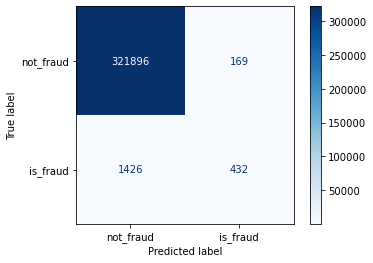

In [236]:
# plot confusion matrix
plot_confusion_matrix(lr, X_test_sc, y_test, display_labels=['not_fraud', 'is_fraud'], 
                      cmap='Blues', values_format='d');

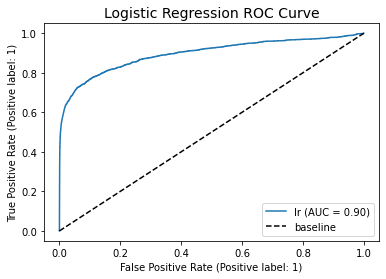

In [237]:
# plot roc curve
plot_roc_curve(lr, X_test_sc, y_test, name = 'lr')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Logistic Regression ROC Curve', fontsize=14)
plt.legend();

In [238]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression GridSearchCV,0.995062,0.995076,0.718802,0.232508,0.17153,0.351362,0.895988


### Gaussian Naive Bayes

In [239]:
%%time

gnb = GaussianNB()

# Fit our model.
gnb.fit(X_train, y_train)

Wall time: 1.85 s


GaussianNB()

In [240]:
# print the summarize report and store the values
run_score(gnb, 'Gaussian Naive Bayes')

====== Gaussian Naive Bayes's Metrics ======
Train Score: 0.9866562938311472
Test Score: 0.9864628322162983
Precision Score: 0.215748031496063
Recall Score: 0.5161463939720129
Average Precision: 0.11413291939541916
f1-Score: 0.3042995399016341
roc_auc Score: 0.918497464483306

== confusion matrix ==
True Negatives: 318579
False Positives: 3486
False Negatives: 899
True Positives: 959


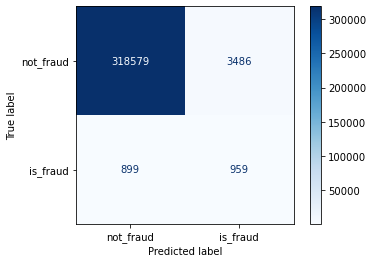

In [241]:
# plot confusion matrix
plot_confusion_matrix(gnb, X_test, y_test, display_labels=['not_fraud', 'is_fraud'], 
                      cmap='Blues', values_format='d');

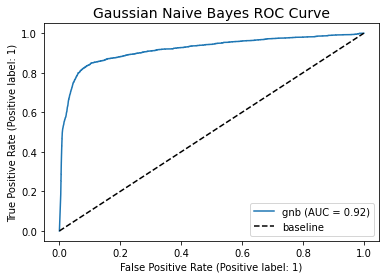

In [242]:
# plot roc curve
plot_roc_curve(gnb, X_test, y_test, name = 'gnb')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Gaussian Naive Bayes ROC Curve', fontsize=14)
plt.legend();

In [243]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression GridSearchCV,0.995062,0.995076,0.718802,0.232508,0.171530,0.351362,0.895988
1,Gaussian Naive Bayes,0.986656,0.986463,0.215748,0.516146,0.114133,0.304300,0.918497


### Random Forest Classifier

In [244]:
%%time

rf = RandomForestClassifier(random_state = 42)

# Fit our model.
rf.fit(X_train, y_train)

Wall time: 4min 30s


RandomForestClassifier(random_state=42)

In [245]:
# print the summarize report and store the values
run_score(rf, 'Random Forest Classifier')

====== Random Forest Classifier's Metrics ======
Train Score: 0.9999989709488571
Test Score: 0.9982928041540736
Precision Score: 0.9924528301886792
Recall Score: 0.7077502691065662
Average Precision: 0.704085081953253
f1-Score: 0.8262645303173107
roc_auc Score: 0.9940300839190692

== confusion matrix ==
True Negatives: 322055
False Positives: 10
False Negatives: 543
True Positives: 1315


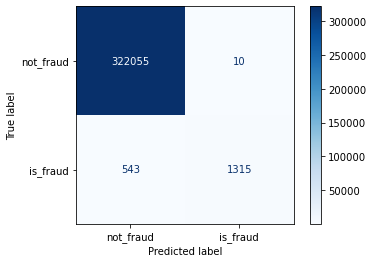

In [246]:
# plot confusion matrix
plot_confusion_matrix(rf, X_test, y_test, display_labels=['not_fraud', 'is_fraud'], 
                      cmap='Blues', values_format='d');

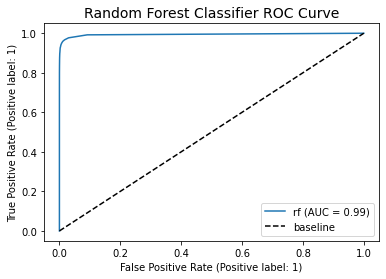

In [247]:
# plot roc curve
plot_roc_curve(rf, X_test, y_test, name = 'rf')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Random Forest Classifier ROC Curve', fontsize=14)
plt.legend();

In [248]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression GridSearchCV,0.995062,0.995076,0.718802,0.232508,0.171530,0.351362,0.895988
1,Gaussian Naive Bayes,0.986656,0.986463,0.215748,0.516146,0.114133,0.304300,0.918497
2,Random Forest Classifier,0.999999,0.998293,0.992453,0.707750,0.704085,0.826265,0.994030


### XGBoost

In [249]:
%%time

# Instantiate the model
xgb = XGBClassifier(objective='binary:logistic', seed=42)

# Fit the model
xgb.fit(X_train, y_train)

C:\Users\chua_\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 49 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [250]:
# print the summarize report and store the values
run_score(xgb, 'XGBClassifier')

====== XGBClassifier's Metrics ======
Train Score: 0.9999001820391472
Test Score: 0.9992559960237464
Precision Score: 0.9758681577398469
Recall Score: 0.8923573735199138
Average Precision: 0.8714405768281345
f1-Score: 0.9322462749508011
roc_auc Score: 0.9994805035461671

== confusion matrix ==
True Negatives: 322024
False Positives: 41
False Negatives: 200
True Positives: 1658


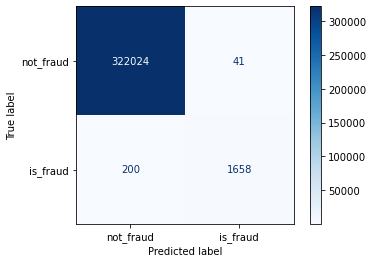

In [251]:
# plot confusion matrix
plot_confusion_matrix(xgb, X_test, y_test, display_labels=['not_fraud', 'is_fraud'], 
                      cmap='Blues', values_format='d');

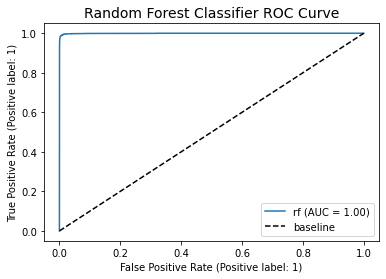

In [252]:
# plot roc curve
plot_roc_curve(xgb, X_test, y_test, name = 'rf')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Random Forest Classifier ROC Curve', fontsize=14)
plt.legend();

In [253]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression GridSearchCV,0.995062,0.995076,0.718802,0.232508,0.171530,0.351362,0.895988
1,Gaussian Naive Bayes,0.986656,0.986463,0.215748,0.516146,0.114133,0.304300,0.918497
2,Random Forest Classifier,0.999999,0.998293,0.992453,0.707750,0.704085,0.826265,0.994030
3,XGBClassifier,0.999900,0.999256,0.975868,0.892357,0.871441,0.932246,0.999481


In [254]:
# !pip install catboost

In [255]:
# Import Bagging Classifier.
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, \
                            GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from catboost import CatBoostClassifier

In [256]:
%%time
cat = CatBoostClassifier(random_seed=42)
cat.fit(X_train, y_train)

Learning rate set to 0.194367
0:	learn: 0.3008623	total: 73.3ms	remaining: 1m 13s
1:	learn: 0.1343093	total: 135ms	remaining: 1m 7s
2:	learn: 0.0586520	total: 199ms	remaining: 1m 6s
3:	learn: 0.0311560	total: 254ms	remaining: 1m 3s
4:	learn: 0.0234491	total: 307ms	remaining: 1m 1s
5:	learn: 0.0171003	total: 359ms	remaining: 59.4s
6:	learn: 0.0143117	total: 419ms	remaining: 59.5s
7:	learn: 0.0126351	total: 477ms	remaining: 59.2s
8:	learn: 0.0104149	total: 533ms	remaining: 58.7s
9:	learn: 0.0096814	total: 589ms	remaining: 58.4s
10:	learn: 0.0089551	total: 654ms	remaining: 58.8s
11:	learn: 0.0083848	total: 717ms	remaining: 59.1s
12:	learn: 0.0078693	total: 778ms	remaining: 59.1s
13:	learn: 0.0075697	total: 835ms	remaining: 58.8s
14:	learn: 0.0073487	total: 886ms	remaining: 58.2s
15:	learn: 0.0070349	total: 942ms	remaining: 57.9s
16:	learn: 0.0067547	total: 1s	remaining: 58s
17:	learn: 0.0065791	total: 1.06s	remaining: 57.9s
18:	learn: 0.0063172	total: 1.11s	remaining: 57.6s
19:	learn: 0.0

163:	learn: 0.0019687	total: 10.1s	remaining: 51.6s
164:	learn: 0.0019637	total: 10.2s	remaining: 51.7s
165:	learn: 0.0019621	total: 10.3s	remaining: 51.7s
166:	learn: 0.0019589	total: 10.3s	remaining: 51.6s
167:	learn: 0.0019392	total: 10.4s	remaining: 51.7s
168:	learn: 0.0019363	total: 10.5s	remaining: 51.7s
169:	learn: 0.0019312	total: 10.6s	remaining: 51.7s
170:	learn: 0.0019257	total: 10.6s	remaining: 51.6s
171:	learn: 0.0019203	total: 10.7s	remaining: 51.5s
172:	learn: 0.0019192	total: 10.8s	remaining: 51.4s
173:	learn: 0.0019098	total: 10.8s	remaining: 51.3s
174:	learn: 0.0019055	total: 10.9s	remaining: 51.3s
175:	learn: 0.0018921	total: 10.9s	remaining: 51.2s
176:	learn: 0.0018816	total: 11s	remaining: 51.1s
177:	learn: 0.0018759	total: 11s	remaining: 51s
178:	learn: 0.0018702	total: 11.1s	remaining: 50.9s
179:	learn: 0.0018683	total: 11.2s	remaining: 50.8s
180:	learn: 0.0018636	total: 11.2s	remaining: 50.7s
181:	learn: 0.0018564	total: 11.3s	remaining: 50.6s
182:	learn: 0.0018

323:	learn: 0.0012773	total: 20.5s	remaining: 42.8s
324:	learn: 0.0012739	total: 20.6s	remaining: 42.8s
325:	learn: 0.0012673	total: 20.7s	remaining: 42.7s
326:	learn: 0.0012651	total: 20.7s	remaining: 42.7s
327:	learn: 0.0012623	total: 20.8s	remaining: 42.6s
328:	learn: 0.0012592	total: 20.9s	remaining: 42.6s
329:	learn: 0.0012566	total: 20.9s	remaining: 42.5s
330:	learn: 0.0012527	total: 21s	remaining: 42.4s
331:	learn: 0.0012470	total: 21.1s	remaining: 42.4s
332:	learn: 0.0012392	total: 21.1s	remaining: 42.3s
333:	learn: 0.0012354	total: 21.2s	remaining: 42.2s
334:	learn: 0.0012330	total: 21.2s	remaining: 42.1s
335:	learn: 0.0012308	total: 21.3s	remaining: 42.1s
336:	learn: 0.0012272	total: 21.3s	remaining: 42s
337:	learn: 0.0012261	total: 21.4s	remaining: 41.9s
338:	learn: 0.0012257	total: 21.4s	remaining: 41.8s
339:	learn: 0.0012239	total: 21.5s	remaining: 41.7s
340:	learn: 0.0012232	total: 21.6s	remaining: 41.7s
341:	learn: 0.0012204	total: 21.6s	remaining: 41.6s
342:	learn: 0.00

484:	learn: 0.0009009	total: 30s	remaining: 31.9s
485:	learn: 0.0008997	total: 30.1s	remaining: 31.8s
486:	learn: 0.0008978	total: 30.1s	remaining: 31.7s
487:	learn: 0.0008952	total: 30.2s	remaining: 31.7s
488:	learn: 0.0008933	total: 30.3s	remaining: 31.6s
489:	learn: 0.0008916	total: 30.3s	remaining: 31.6s
490:	learn: 0.0008895	total: 30.4s	remaining: 31.5s
491:	learn: 0.0008866	total: 30.4s	remaining: 31.4s
492:	learn: 0.0008853	total: 30.5s	remaining: 31.4s
493:	learn: 0.0008843	total: 30.5s	remaining: 31.3s
494:	learn: 0.0008831	total: 30.6s	remaining: 31.2s
495:	learn: 0.0008821	total: 30.7s	remaining: 31.2s
496:	learn: 0.0008804	total: 30.7s	remaining: 31.1s
497:	learn: 0.0008790	total: 30.8s	remaining: 31s
498:	learn: 0.0008769	total: 30.8s	remaining: 31s
499:	learn: 0.0008728	total: 30.9s	remaining: 30.9s
500:	learn: 0.0008713	total: 30.9s	remaining: 30.8s
501:	learn: 0.0008708	total: 31s	remaining: 30.8s
502:	learn: 0.0008687	total: 31.1s	remaining: 30.7s
503:	learn: 0.000867

643:	learn: 0.0006592	total: 38.9s	remaining: 21.5s
644:	learn: 0.0006583	total: 39s	remaining: 21.5s
645:	learn: 0.0006570	total: 39.1s	remaining: 21.4s
646:	learn: 0.0006544	total: 39.1s	remaining: 21.3s
647:	learn: 0.0006526	total: 39.2s	remaining: 21.3s
648:	learn: 0.0006515	total: 39.2s	remaining: 21.2s
649:	learn: 0.0006504	total: 39.3s	remaining: 21.1s
650:	learn: 0.0006498	total: 39.3s	remaining: 21.1s
651:	learn: 0.0006485	total: 39.4s	remaining: 21s
652:	learn: 0.0006468	total: 39.4s	remaining: 21s
653:	learn: 0.0006456	total: 39.5s	remaining: 20.9s
654:	learn: 0.0006450	total: 39.6s	remaining: 20.8s
655:	learn: 0.0006438	total: 39.6s	remaining: 20.8s
656:	learn: 0.0006430	total: 39.7s	remaining: 20.7s
657:	learn: 0.0006419	total: 39.8s	remaining: 20.7s
658:	learn: 0.0006408	total: 39.8s	remaining: 20.6s
659:	learn: 0.0006386	total: 39.9s	remaining: 20.5s
660:	learn: 0.0006375	total: 39.9s	remaining: 20.5s
661:	learn: 0.0006353	total: 40s	remaining: 20.4s
662:	learn: 0.000632

804:	learn: 0.0004885	total: 47.8s	remaining: 11.6s
805:	learn: 0.0004883	total: 47.9s	remaining: 11.5s
806:	learn: 0.0004878	total: 48s	remaining: 11.5s
807:	learn: 0.0004877	total: 48s	remaining: 11.4s
808:	learn: 0.0004873	total: 48.1s	remaining: 11.3s
809:	learn: 0.0004870	total: 48.1s	remaining: 11.3s
810:	learn: 0.0004862	total: 48.2s	remaining: 11.2s
811:	learn: 0.0004855	total: 48.2s	remaining: 11.2s
812:	learn: 0.0004851	total: 48.3s	remaining: 11.1s
813:	learn: 0.0004834	total: 48.3s	remaining: 11s
814:	learn: 0.0004824	total: 48.4s	remaining: 11s
815:	learn: 0.0004816	total: 48.5s	remaining: 10.9s
816:	learn: 0.0004812	total: 48.5s	remaining: 10.9s
817:	learn: 0.0004804	total: 48.6s	remaining: 10.8s
818:	learn: 0.0004800	total: 48.6s	remaining: 10.8s
819:	learn: 0.0004795	total: 48.7s	remaining: 10.7s
820:	learn: 0.0004764	total: 48.8s	remaining: 10.6s
821:	learn: 0.0004756	total: 48.9s	remaining: 10.6s
822:	learn: 0.0004751	total: 48.9s	remaining: 10.5s
823:	learn: 0.000474

963:	learn: 0.0003734	total: 57.3s	remaining: 2.14s
964:	learn: 0.0003733	total: 57.4s	remaining: 2.08s
965:	learn: 0.0003723	total: 57.4s	remaining: 2.02s
966:	learn: 0.0003722	total: 57.5s	remaining: 1.96s
967:	learn: 0.0003707	total: 57.5s	remaining: 1.9s
968:	learn: 0.0003702	total: 57.6s	remaining: 1.84s
969:	learn: 0.0003698	total: 57.7s	remaining: 1.78s
970:	learn: 0.0003692	total: 57.7s	remaining: 1.72s
971:	learn: 0.0003692	total: 57.8s	remaining: 1.66s
972:	learn: 0.0003691	total: 57.8s	remaining: 1.6s
973:	learn: 0.0003688	total: 57.9s	remaining: 1.54s
974:	learn: 0.0003686	total: 57.9s	remaining: 1.48s
975:	learn: 0.0003681	total: 58s	remaining: 1.43s
976:	learn: 0.0003673	total: 58s	remaining: 1.37s
977:	learn: 0.0003667	total: 58.1s	remaining: 1.31s
978:	learn: 0.0003646	total: 58.2s	remaining: 1.25s
979:	learn: 0.0003638	total: 58.2s	remaining: 1.19s
980:	learn: 0.0003632	total: 58.3s	remaining: 1.13s
981:	learn: 0.0003626	total: 58.3s	remaining: 1.07s
982:	learn: 0.0003

In [257]:
# print the summarize report and store the values
run_score(cat, 'CatBoostClassifier')

====== CatBoostClassifier's Metrics ======
Train Score: 0.9999536926985734
Test Score: 0.999246734563461
Precision Score: 0.9724824355971897
Recall Score: 0.8939720129171151
Average Precision: 0.8699802497027608
f1-Score: 0.93157599551318
roc_auc Score: 0.999425662006832

== confusion matrix ==
True Negatives: 322018
False Positives: 47
False Negatives: 197
True Positives: 1661


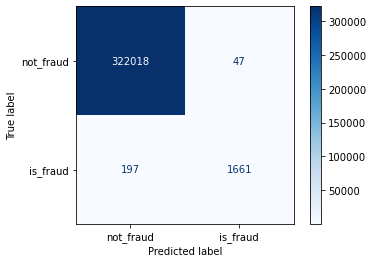

In [258]:
# plot confusion matrix
plot_confusion_matrix(cat, X_test, y_test, display_labels=['not_fraud', 'is_fraud'], 
                      cmap='Blues', values_format='d');

In [259]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression GridSearchCV,0.995062,0.995076,0.718802,0.232508,0.171530,0.351362,0.895988
1,Gaussian Naive Bayes,0.986656,0.986463,0.215748,0.516146,0.114133,0.304300,0.918497
2,Random Forest Classifier,0.999999,0.998293,0.992453,0.707750,0.704085,0.826265,0.994030
3,XGBClassifier,0.999900,0.999256,0.975868,0.892357,0.871441,0.932246,0.999481
4,CatBoostClassifier,0.999954,0.999247,0.972482,0.893972,0.869980,0.931576,0.999426


In [260]:
# %%time
# svc = SVC(random_state = 42)
# svc.fit(X_train, y_train)

In [261]:
%%time

bag = BaggingClassifier(random_state = 42)
bag.fit(X_train, y_train)


Wall time: 3min 46s


BaggingClassifier(random_state=42)

In [262]:
# print the summarize report and store the values
run_score(bag, 'BaggingClassifier')

====== BaggingClassifier's Metrics ======
Train Score: 0.9998394680217212
Test Score: 0.9987898358560522
Precision Score: 0.960427135678392
Recall Score: 0.8229278794402584
Average Precision: 0.7913779395986565
f1-Score: 0.8863768115942029
roc_auc Score: 0.9648528467157335

== confusion matrix ==
True Negatives: 322002
False Positives: 63
False Negatives: 329
True Positives: 1529


In [263]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression GridSearchCV,0.995062,0.995076,0.718802,0.232508,0.171530,0.351362,0.895988
1,Gaussian Naive Bayes,0.986656,0.986463,0.215748,0.516146,0.114133,0.304300,0.918497
2,Random Forest Classifier,0.999999,0.998293,0.992453,0.707750,0.704085,0.826265,0.994030
3,XGBClassifier,0.999900,0.999256,0.975868,0.892357,0.871441,0.932246,0.999481
4,CatBoostClassifier,0.999954,0.999247,0.972482,0.893972,0.869980,0.931576,0.999426
5,BaggingClassifier,0.999839,0.998790,0.960427,0.822928,0.791378,0.886377,0.964853


In [264]:
%%time

et = ExtraTreesClassifier(random_state = 42)
# Updated evaluation list
pd.DataFrame(evaluation_list)

et.fit(X_train, y_train)


Wall time: 3min 17s


ExtraTreesClassifier(random_state=42)

In [265]:
# print the summarize report and store the values
run_score(et, 'ExtraTreesClassifier')

====== ExtraTreesClassifier's Metrics ======
Train Score: 1.0
Test Score: 0.9975673230983907
Precision Score: 0.9990671641791045
Recall Score: 0.5764262648008611
Average Precision: 0.5783181434811308
f1-Score: 0.7310580204778158
roc_auc Score: 0.9915065901843019

== confusion matrix ==
True Negatives: 322064
False Positives: 1
False Negatives: 787
True Positives: 1071


In [266]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression GridSearchCV,0.995062,0.995076,0.718802,0.232508,0.171530,0.351362,0.895988
1,Gaussian Naive Bayes,0.986656,0.986463,0.215748,0.516146,0.114133,0.304300,0.918497
2,Random Forest Classifier,0.999999,0.998293,0.992453,0.707750,0.704085,0.826265,0.994030
3,XGBClassifier,0.999900,0.999256,0.975868,0.892357,0.871441,0.932246,0.999481
4,CatBoostClassifier,0.999954,0.999247,0.972482,0.893972,0.869980,0.931576,0.999426
5,BaggingClassifier,0.999839,0.998790,0.960427,0.822928,0.791378,0.886377,0.964853
6,ExtraTreesClassifier,1.000000,0.997567,0.999067,0.576426,0.578318,0.731058,0.991507


In [267]:
%%time

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada.fit(X_train, y_train)

Wall time: 34.7 s


AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [268]:
# print the summarize report and store the values
run_score(ada, 'AdaBoostClassifier')

====== AdaBoostClassifier's Metrics ======
Train Score: 1.0
Test Score: 0.998048919033227
Precision Score: 0.8243386243386244
Recall Score: 0.8385360602798708
Average Precision: 0.69216380841797
f1-Score: 0.8313767342582711
roc_auc Score: 0.918752606234823

== confusion matrix ==
True Negatives: 321733
False Positives: 332
False Negatives: 300
True Positives: 1558


In [269]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression GridSearchCV,0.995062,0.995076,0.718802,0.232508,0.171530,0.351362,0.895988
1,Gaussian Naive Bayes,0.986656,0.986463,0.215748,0.516146,0.114133,0.304300,0.918497
2,Random Forest Classifier,0.999999,0.998293,0.992453,0.707750,0.704085,0.826265,0.994030
3,XGBClassifier,0.999900,0.999256,0.975868,0.892357,0.871441,0.932246,0.999481
4,CatBoostClassifier,0.999954,0.999247,0.972482,0.893972,0.869980,0.931576,0.999426
5,BaggingClassifier,0.999839,0.998790,0.960427,0.822928,0.791378,0.886377,0.964853
6,ExtraTreesClassifier,1.000000,0.997567,0.999067,0.576426,0.578318,0.731058,0.991507
7,AdaBoostClassifier,1.000000,0.998049,0.824339,0.838536,0.692164,0.831377,0.918753


In [270]:
%%time

gboost = GradientBoostingClassifier()
gboost.fit(X_train, y_train)

Wall time: 9min 2s


GradientBoostingClassifier()

In [271]:
# print the summarize report and store the values
run_score(gboost, 'GradientBoostingClassifier')

====== GradientBoostingClassifier's Metrics ======
Train Score: 0.9984142321889256
Test Score: 0.9983298499952149
Precision Score: 0.9240180296200902
Recall Score: 0.7723358449946178
Average Precision: 0.7149581115971235
f1-Score: 0.8413954851949574
roc_auc Score: 0.9881136824986538

== confusion matrix ==
True Negatives: 321947
False Positives: 118
False Negatives: 423
True Positives: 1435


In [272]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression GridSearchCV,0.995062,0.995076,0.718802,0.232508,0.171530,0.351362,0.895988
1,Gaussian Naive Bayes,0.986656,0.986463,0.215748,0.516146,0.114133,0.304300,0.918497
2,Random Forest Classifier,0.999999,0.998293,0.992453,0.707750,0.704085,0.826265,0.994030
3,XGBClassifier,0.999900,0.999256,0.975868,0.892357,0.871441,0.932246,0.999481
4,CatBoostClassifier,0.999954,0.999247,0.972482,0.893972,0.869980,0.931576,0.999426
5,BaggingClassifier,0.999839,0.998790,0.960427,0.822928,0.791378,0.886377,0.964853
6,ExtraTreesClassifier,1.000000,0.997567,0.999067,0.576426,0.578318,0.731058,0.991507
7,AdaBoostClassifier,1.000000,0.998049,0.824339,0.838536,0.692164,0.831377,0.918753
8,GradientBoostingClassifier,0.998414,0.998330,0.924018,0.772336,0.714958,0.841395,0.988114


In [83]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense # equal to fully connected
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import EarlyStopping


In [84]:
# Instantiate model
model = Sequential()

In [85]:
# One by one, add Dense layers to our model.
# The hidden layers will use the ReLU activation
# Output layer will have softmax
model.add(Dense(256, activation="relu", input_shape= (X_train_sc.shape[1],))) 
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [86]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

# We need to compile our model in Keras.
# Need to tell it three things:
# Optimizer (for us, usually Adam)
# Loss (which?)
# Metrics (Definitely need accuracy, but could do more)

#opt = SGD(learning_rate=0.01)
#opt = Adam(learning_rate=0.001) #10 to 20 epoch is max, if want then can increase the learning_rate

model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=metrics
)

# Model Fit
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=10, 
                           mode='auto')

In [87]:
# Fit!
# Need to specify batch_size and epochs
# Can validate with validation_split
hist = model.fit(
    X_train_sc, y_train,
    batch_size=256,
    epochs=70,
    validation_data=(X_test_sc, y_test),
    callbacks=[early_stop] # Add your callbacks here!
)

Epoch 1/70
3796/3796 [==============================] - 7s 2ms/step - loss: 0.0338 - fn: 4462.0000 - fp: 3848.0000 - tn: 962348.0000 - tp: 1111.0000 - precision: 0.2240 - recall: 0.1994 - val_loss: 0.0163 - val_fn: 1109.0000 - val_fp: 63.0000 - val_tn: 322002.0000 - val_tp: 749.0000 - val_precision: 0.9224 - val_recall: 0.4031
Epoch 2/70
3796/3796 [==============================] - 6s 2ms/step - loss: 0.0140 - fn: 3003.0000 - fp: 190.0000 - tn: 966006.0000 - tp: 2570.0000 - precision: 0.9312 - recall: 0.4612 - val_loss: 0.0135 - val_fn: 960.0000 - val_fp: 56.0000 - val_tn: 322009.0000 - val_tp: 898.0000 - val_precision: 0.9413 - val_recall: 0.4833
Epoch 3/70
3796/3796 [==============================] - 7s 2ms/step - loss: 0.0116 - fn: 2490.0000 - fp: 212.0000 - tn: 965984.0000 - tp: 3083.0000 - precision: 0.9357 - recall: 0.5532 - val_loss: 0.0118 - val_fn: 782.0000 - val_fp: 93.0000 - val_tn: 321972.0000 - val_tp: 1076.0000 - val_precision: 0.9204 - val_recall: 0.5791
Epoch 4/70
3796/

Epoch 26/70
3796/3796 [==============================] - 7s 2ms/step - loss: 0.0023 - fn: 536.0000 - fp: 109.0000 - tn: 966087.0000 - tp: 5037.0000 - precision: 0.9788 - recall: 0.9038 - val_loss: 0.0070 - val_fn: 422.0000 - val_fp: 105.0000 - val_tn: 321960.0000 - val_tp: 1436.0000 - val_precision: 0.9319 - val_recall: 0.7729
Epoch 27/70
3796/3796 [==============================] - 8s 2ms/step - loss: 0.0022 - fn: 513.0000 - fp: 98.0000 - tn: 966098.0000 - tp: 5060.0000 - precision: 0.9810 - recall: 0.9079 - val_loss: 0.0072 - val_fn: 432.0000 - val_fp: 78.0000 - val_tn: 321987.0000 - val_tp: 1426.0000 - val_precision: 0.9481 - val_recall: 0.7675
Epoch 28/70
3796/3796 [==============================] - 7s 2ms/step - loss: 0.0021 - fn: 487.0000 - fp: 90.0000 - tn: 966106.0000 - tp: 5086.0000 - precision: 0.9826 - recall: 0.9126 - val_loss: 0.0070 - val_fn: 386.0000 - val_fp: 156.0000 - val_tn: 321909.0000 - val_tp: 1472.0000 - val_precision: 0.9042 - val_recall: 0.7922
Epoch 29/70
3796

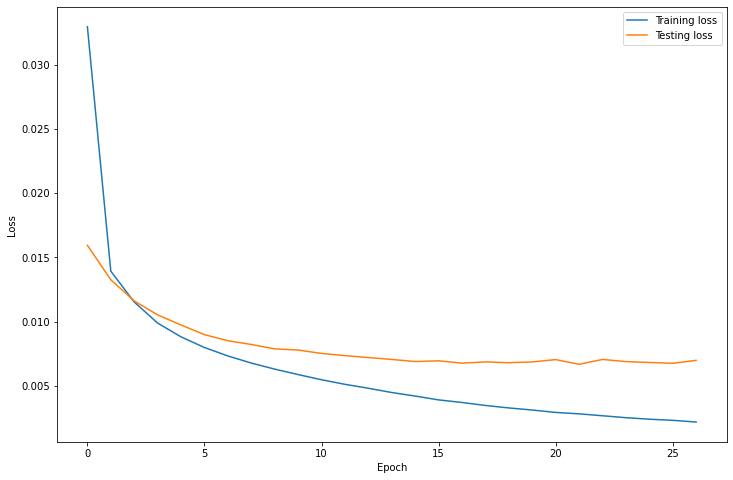

In [78]:
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

### Isolation Forest

In [275]:
from sklearn.ensemble import IsolationForest #unsupervised model

In [361]:
%%time

isof = IsolationForest(n_estimators=300,max_samples='auto', random_state=42, max_features=10, contamination=0.2)
isof.fit(X_test)

Wall time: 27.7 s


IsolationForest(contamination=0.2, max_features=10, n_estimators=300,
                random_state=42)

In [362]:
isof.decision_function(X_test)

array([-0.00429815, -0.00470222,  0.00952013, ...,  0.00248539,
       -0.00167395,  0.01878733])

In [363]:
isof_df = X_test.copy()

In [364]:
isof_df['scores'] = isof.decision_function(X_test)

In [365]:
isof_df['anomaly_score'] = isof.predict(X_test)

In [366]:
isof_df['anomaly_score'].value_counts()

 1    259138
-1     64785
Name: anomaly_score, dtype: int64

In [367]:
isof_df['anomaly_score'] = isof_df['anomaly_score'].map({1:0, -1:1})

In [368]:
isof_df[isof_df['anomaly_score'] == 0].head()

,amt,gender,lat,long,city_pop,merch_lat,merch_long,trans_year,trans_month,trans_week,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,scores,anomaly_score
972892,51.93,0,30.5920,-97.2893,1766,30.394796,-96.993281,2020,1,5,...,1,0,0,0,0,0,0,0,0.009520,0
602015,45.71,0,30.6576,-91.6264,1178,30.579323,-91.909866,2019,9,37,...,0,0,0,0,0,0,0,0,0.004941,0
991252,42.64,0,45.8327,-91.0144,1478,44.984610,-90.928320,2020,2,6,...,0,0,0,0,0,1,0,0,0.004859,0
416961,203.46,0,33.7467,-117.1721,54287,34.371357,-117.375605,2019,7,27,...,0,0,0,0,0,0,0,0,0.005501,0
124787,16.31,0,41.0767,-74.5982,2456,41.953531,-73.738652,2019,3,10,...,0,0,0,0,0,0,0,0,0.003507,0


In [369]:
isof_df['is_fraud'] = y_test

In [370]:
isof_df[(isof_df['anomaly_score'] == 1) & (isof_df['is_fraud'] == 1)].head()

,amt,gender,lat,long,city_pop,merch_lat,merch_long,trans_year,trans_month,trans_week,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,scores,anomaly_score,is_fraud
1097799,327.93,0,37.7256,-81.1087,3994,37.502289,-80.131803,2020,4,14,...,0,0,0,0,0,1,0,-0.012683,1,1
1182318,14.62,1,31.8092,-106.4247,749635,31.564330,-107.181624,2020,5,19,...,0,0,0,0,0,0,0,-0.010178,1,1
36187,746.76,0,27.4703,-81.4872,50835,28.213586,-80.990412,2019,1,4,...,0,0,0,0,0,0,0,-0.022666,1,1
55483,20.13,0,46.1838,-101.2589,77,45.244930,-101.171103,2019,2,5,...,0,0,0,0,0,0,0,-0.008105,1,1
98005,874.98,0,40.9086,-73.8221,67100,41.050200,-74.083291,2019,2,9,...,0,0,0,0,0,0,0,-0.023307,1,1


In [371]:
isof_df[(isof_df['anomaly_score'] == 0) & (isof_df['is_fraud'] == 1)]

,amt,gender,lat,long,city_pop,merch_lat,merch_long,trans_year,trans_month,trans_week,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,scores,anomaly_score,is_fraud
423267,569.01,0,34.4596,-93.6743,1383,33.680223,-94.545012,2019,7,28,...,0,0,0,0,0,0,0,0.003025,0,1
1185926,17.99,0,42.1782,-83.2461,15623,42.440892,-82.951309,2020,5,19,...,0,0,0,0,0,0,0,0.003773,0,1
276323,989.16,0,34.3470,-87.7154,5778,34.928611,-88.653070,2019,5,20,...,0,0,0,0,0,0,0,0.009556,0,1
376293,17.81,1,26.1184,-81.7361,276002,26.034018,-81.165716,2019,6,25,...,0,0,0,0,0,0,0,0.004060,0,1
841989,11.82,1,36.5422,-88.3319,1480,35.685682,-88.272868,2019,12,50,...,0,0,0,0,0,0,0,0.002494,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685858,18.29,0,42.8948,-74.8209,824,43.705239,-74.423520,2019,10,42,...,0,0,0,0,0,0,0,0.021122,0,1
423293,922.33,0,40.4815,-92.9951,3805,40.641401,-93.820428,2019,7,28,...,0,0,0,0,0,0,0,0.005289,0,1
154235,18.35,0,36.5220,-87.3490,151785,36.754307,-88.172838,2019,3,12,...,0,0,0,0,0,0,0,0.013764,0,1
690760,18.60,0,43.7893,-75.4156,8830,43.242477,-75.526455,2019,10,43,...,0,0,0,0,0,0,0,0.010449,0,1


In [372]:
print(confusion_matrix(y_test, isof_df['anomaly_score']))

[[258584  63481]
 [   554   1304]]


In [273]:
# %%time
# knn = KNeighborsClassifier()
# knn.fit(X_train, y_train)

In [274]:
# # plot confusion matrix
# plot_confusion_matrix(knn, X_test, y_test, display_labels=['not_fraud', 'is_fraud'], 
#                       cmap='Blues', values_format='d');

NameError: name 'knn' is not defined

In [ ]:
# # print the summarize report and store the values
# run_score(knn, 'KNeighborsClassifier')

In [ ]:
# # Updated evaluation list
# pd.DataFrame(evaluation_list)